In this notebook, I am going to implement GAN Network. 
GAN (Generative Adversial network) is a network which use to generate Fake or synthetic data which extremely looks like real one. 

GAN network presented by Ian GoodFellow. Paper link <a href = "https://papers.nips.cc/paper/5423-generative-adversarial-nets.pdf"> GAN PAPER</a>

I am using CIFAR 10 dataset which has 10 classes. Link to Dataset: https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz

In [13]:
import tensorflow as tf
import numpy as np
# from scipy.io import loadmat
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_olivetti_faces
%matplotlib inline

In [14]:
data = fetch_olivetti_faces('/tmp/olivetti_face')

downloading Olivetti faces from https://ndownloader.figshare.com/files/5976027 to /tmp/olivetti_face


In [17]:
data['data'].shape

(400, 4096)

In [18]:
def display_image(images, size):
    n = len(images)
    plt.figure()
    plt.gca().set_axis_off()
    im = np.vstack([np.hstack([images[np.random.choice(n)] for i in range(size)])
                    for i in range(size)])
     plt.imshow(im, plt.cm.gray)
     plt.show()


In [19]:
images = np.transpose(data['data'].reshape(64, 64, 400), axes= (2, 1, 0))

In [ ]:
images.shape

In [3]:
display_image(images, 3)

NameError: name 'display_image' is not defined

In [8]:
tf.reset_default_graph()

fake_inputs = tf.placeholder(tf.float32, (None, 4096), 'FakeInputImage')
real_inputs = tf.placeholder(tf.float32, (None, 4096), 'RealInputImage')


In [9]:
def Generative_Model(x, reuse = False):
    
    neurons = [1024, 1024, 1024, 4096]
    with tf.variable_scope('Generative_Model', reuse = reuse) as gen:
        
        A1 = tf.layers.dense(x, neurons[0], activation = tf.nn.relu)
        
        A2 = tf.layers.dense(A1, neurons[1], activation = tf.nn.relu)
        
        A3 = tf.layers.dense(A2, neurons[2], activation = tf.nn.relu)
        
        A4 = tf.layers.dense(A3, neurons[3], activation = tf.nn.tanh)
        
        return A4

In [10]:
def Discriminative_Model(x, reuse = False):
    
    neurons = [1024, 1024, 1]
    
    with tf.variable_scope('Discriminative_Model', reuse = reuse) as dis:
        
        A1 = tf.layers.dense(x, neurons[0], activation = tf.nn.relu)
        
        A2 = tf.layers.dense(A1, neurons[1], activation = tf.nn.relu)
        
        A3 = tf.layers.dense(A2, neurons[2], activation= tf.sigmoid)
        
        return A3

In [11]:
fake_images = Generative_Model(fake_inputs, False)

dis_real_out = Discriminative_Model(real_inputs, False)
dis_fake_out = Discriminative_Model(fake_images, True)

Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Colocations handled automatically by placer.


In [12]:
tf.trainable_variables()

[<tf.Variable 'Generative_Model/dense/kernel:0' shape=(4096, 1024) dtype=float32_ref>,
 <tf.Variable 'Generative_Model/dense/bias:0' shape=(1024,) dtype=float32_ref>,
 <tf.Variable 'Generative_Model/dense_1/kernel:0' shape=(1024, 1024) dtype=float32_ref>,
 <tf.Variable 'Generative_Model/dense_1/bias:0' shape=(1024,) dtype=float32_ref>,
 <tf.Variable 'Generative_Model/dense_2/kernel:0' shape=(1024, 1024) dtype=float32_ref>,
 <tf.Variable 'Generative_Model/dense_2/bias:0' shape=(1024,) dtype=float32_ref>,
 <tf.Variable 'Generative_Model/dense_3/kernel:0' shape=(1024, 4096) dtype=float32_ref>,
 <tf.Variable 'Generative_Model/dense_3/bias:0' shape=(4096,) dtype=float32_ref>,
 <tf.Variable 'Discriminative_Model/dense/kernel:0' shape=(4096, 1024) dtype=float32_ref>,
 <tf.Variable 'Discriminative_Model/dense/bias:0' shape=(1024,) dtype=float32_ref>,
 <tf.Variable 'Discriminative_Model/dense_1/kernel:0' shape=(1024, 1024) dtype=float32_ref>,
 <tf.Variable 'Discriminative_Model/dense_1/bias:0' 

In [13]:
g_vars = [i for i in tf.trainable_variables() if 'Generative' in i.name]
d_vars = [i for i in tf.trainable_variables() if 'Discriminative' in i.name]

In [14]:
with tf.variable_scope('LossAndOptimizer') as loss:
    
    ## Calculating Loss for Discrimative Model
    dis_fake_label = tf.zeros_like(dis_fake_out)
    dis_real_label = tf.ones_like(dis_real_out)
    
    dis_fake_loss = tf.nn.sigmoid_cross_entropy_with_logits(logits = dis_fake_out, labels = dis_fake_label)
    dis_real_loss = tf.nn.sigmoid_cross_entropy_with_logits(logits = dis_real_out, labels= dis_real_label)

    dis_loss = tf.reduce_mean(dis_fake_loss + dis_real_loss)
    
    ## Calculating Loss for Generative Model 
    gen_label = tf.ones_like(dis_fake_out)
    gen_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = dis_fake_out, labels = gen_label))
    
    ## Creating Optimizer
    
    lr = 0.01
    
#     optimizer = tf.train.AdamOptimizer(lr)
    g_step = tf.train.AdamOptimizer(lr).minimize(gen_loss, var_list = g_vars)
    d_step = tf.train.AdamOptimizer(lr).minimize(dis_loss, var_list = d_vars)

In [15]:
epochs = 1000
batch_size = 512
gen_loss_dir = []
dis_loss_dir = []

with tf.Session() as sess:
    
    sess.run(tf.global_variables_initializer())

    for epoch in range(epochs):
        
        rand_index = np.random.randint(0, images.shape[0], batch_size)
        original_image = images[rand_index].reshape(-1, 4096)
    
        rand_images = np.random.normal(0, 1, (batch_size, 4096))
    
        sess.run(d_step, feed_dict = {fake_inputs: rand_images, real_inputs: original_image})
        sess.run(g_step, feed_dict = {fake_inputs: rand_images})
        
        g_loss = sess.run(gen_loss, feed_dict = {fake_inputs: rand_images})
        d_loss = sess.run(dis_loss, feed_dict = {real_inputs: original_image,  fake_inputs: rand_images})
        
        gen_loss_dir.append(g_loss)
        dis_loss_dir.append(d_loss)
        print ('Iteration : {} Generative Loss: {:.4f}  Discriminative Loss: {:.4f}'.format(epoch, g_loss, d_loss))
        
    fake = sess.run(Generative_Model(fake_inputs, True), feed_dict = {fake_inputs: np.random.normal(0, 1, (25, 4096))})

Iteration : 0 Generative Loss: 0.6931  Discriminative Loss: 1.3863
Iteration : 1 Generative Loss: 0.6931  Discriminative Loss: 1.3863
Iteration : 2 Generative Loss: 0.6931  Discriminative Loss: 1.3863
Iteration : 3 Generative Loss: 0.6931  Discriminative Loss: 1.3863
Iteration : 4 Generative Loss: 0.6931  Discriminative Loss: 1.3863
Iteration : 5 Generative Loss: 0.6931  Discriminative Loss: 1.3863
Iteration : 6 Generative Loss: 0.6931  Discriminative Loss: 1.3863
Iteration : 7 Generative Loss: 0.6931  Discriminative Loss: 1.3863
Iteration : 8 Generative Loss: 0.6931  Discriminative Loss: 1.3863
Iteration : 9 Generative Loss: 0.6931  Discriminative Loss: 1.3863
Iteration : 10 Generative Loss: 0.6931  Discriminative Loss: 1.3863
Iteration : 11 Generative Loss: 0.6931  Discriminative Loss: 1.3863
Iteration : 12 Generative Loss: 0.6931  Discriminative Loss: 1.3863
Iteration : 13 Generative Loss: 0.6931  Discriminative Loss: 1.3863
Iteration : 14 Generative Loss: 0.6931  Discriminative Los

Iteration : 121 Generative Loss: 0.6931  Discriminative Loss: 1.3863
Iteration : 122 Generative Loss: 0.6931  Discriminative Loss: 1.3863
Iteration : 123 Generative Loss: 0.6931  Discriminative Loss: 1.3863
Iteration : 124 Generative Loss: 0.6931  Discriminative Loss: 1.3863
Iteration : 125 Generative Loss: 0.6931  Discriminative Loss: 1.3863
Iteration : 126 Generative Loss: 0.6931  Discriminative Loss: 1.3863
Iteration : 127 Generative Loss: 0.6931  Discriminative Loss: 1.3863
Iteration : 128 Generative Loss: 0.6931  Discriminative Loss: 1.3863
Iteration : 129 Generative Loss: 0.6931  Discriminative Loss: 1.3863
Iteration : 130 Generative Loss: 0.6931  Discriminative Loss: 1.3863
Iteration : 131 Generative Loss: 0.6931  Discriminative Loss: 1.3863
Iteration : 132 Generative Loss: 0.6931  Discriminative Loss: 1.3863
Iteration : 133 Generative Loss: 0.6931  Discriminative Loss: 1.3863
Iteration : 134 Generative Loss: 0.6931  Discriminative Loss: 1.3863
Iteration : 135 Generative Loss: 0

Iteration : 240 Generative Loss: 0.6931  Discriminative Loss: 1.3863
Iteration : 241 Generative Loss: 0.6931  Discriminative Loss: 1.3863
Iteration : 242 Generative Loss: 0.6931  Discriminative Loss: 1.3863
Iteration : 243 Generative Loss: 0.6931  Discriminative Loss: 1.3863
Iteration : 244 Generative Loss: 0.6931  Discriminative Loss: 1.3863
Iteration : 245 Generative Loss: 0.6931  Discriminative Loss: 1.3863
Iteration : 246 Generative Loss: 0.6931  Discriminative Loss: 1.3863
Iteration : 247 Generative Loss: 0.6931  Discriminative Loss: 1.3863
Iteration : 248 Generative Loss: 0.6931  Discriminative Loss: 1.3863
Iteration : 249 Generative Loss: 0.6931  Discriminative Loss: 1.3863
Iteration : 250 Generative Loss: 0.6931  Discriminative Loss: 1.3863
Iteration : 251 Generative Loss: 0.6931  Discriminative Loss: 1.3863
Iteration : 252 Generative Loss: 0.6931  Discriminative Loss: 1.3863
Iteration : 253 Generative Loss: 0.6931  Discriminative Loss: 1.3863
Iteration : 254 Generative Loss: 0

Iteration : 359 Generative Loss: 0.6931  Discriminative Loss: 1.3863
Iteration : 360 Generative Loss: 0.6931  Discriminative Loss: 1.3863
Iteration : 361 Generative Loss: 0.6931  Discriminative Loss: 1.3863
Iteration : 362 Generative Loss: 0.6931  Discriminative Loss: 1.3863
Iteration : 363 Generative Loss: 0.6931  Discriminative Loss: 1.3863
Iteration : 364 Generative Loss: 0.6931  Discriminative Loss: 1.3863
Iteration : 365 Generative Loss: 0.6931  Discriminative Loss: 1.3863
Iteration : 366 Generative Loss: 0.6931  Discriminative Loss: 1.3863
Iteration : 367 Generative Loss: 0.6931  Discriminative Loss: 1.3863
Iteration : 368 Generative Loss: 0.6931  Discriminative Loss: 1.3863
Iteration : 369 Generative Loss: 0.6931  Discriminative Loss: 1.3863
Iteration : 370 Generative Loss: 0.6931  Discriminative Loss: 1.3863
Iteration : 371 Generative Loss: 0.6931  Discriminative Loss: 1.3863
Iteration : 372 Generative Loss: 0.6931  Discriminative Loss: 1.3863
Iteration : 373 Generative Loss: 0

Iteration : 478 Generative Loss: 0.6931  Discriminative Loss: 1.3863
Iteration : 479 Generative Loss: 0.6931  Discriminative Loss: 1.3863
Iteration : 480 Generative Loss: 0.6931  Discriminative Loss: 1.3863
Iteration : 481 Generative Loss: 0.6931  Discriminative Loss: 1.3863
Iteration : 482 Generative Loss: 0.6931  Discriminative Loss: 1.3863
Iteration : 483 Generative Loss: 0.6931  Discriminative Loss: 1.3863
Iteration : 484 Generative Loss: 0.6931  Discriminative Loss: 1.3863
Iteration : 485 Generative Loss: 0.6931  Discriminative Loss: 1.3863
Iteration : 486 Generative Loss: 0.6931  Discriminative Loss: 1.3863
Iteration : 487 Generative Loss: 0.6931  Discriminative Loss: 1.3863
Iteration : 488 Generative Loss: 0.6931  Discriminative Loss: 1.3863
Iteration : 489 Generative Loss: 0.6931  Discriminative Loss: 1.3863
Iteration : 490 Generative Loss: 0.6931  Discriminative Loss: 1.3863
Iteration : 491 Generative Loss: 0.6931  Discriminative Loss: 1.3863
Iteration : 492 Generative Loss: 0

Iteration : 597 Generative Loss: 0.6931  Discriminative Loss: 1.3863
Iteration : 598 Generative Loss: 0.6931  Discriminative Loss: 1.3863
Iteration : 599 Generative Loss: 0.6931  Discriminative Loss: 1.3863
Iteration : 600 Generative Loss: 0.6931  Discriminative Loss: 1.3863
Iteration : 601 Generative Loss: 0.6931  Discriminative Loss: 1.3863
Iteration : 602 Generative Loss: 0.6931  Discriminative Loss: 1.3863
Iteration : 603 Generative Loss: 0.6931  Discriminative Loss: 1.3863
Iteration : 604 Generative Loss: 0.6931  Discriminative Loss: 1.3863
Iteration : 605 Generative Loss: 0.6931  Discriminative Loss: 1.3863
Iteration : 606 Generative Loss: 0.6931  Discriminative Loss: 1.3863
Iteration : 607 Generative Loss: 0.6931  Discriminative Loss: 1.3863
Iteration : 608 Generative Loss: 0.6931  Discriminative Loss: 1.3863
Iteration : 609 Generative Loss: 0.6931  Discriminative Loss: 1.3863
Iteration : 610 Generative Loss: 0.6931  Discriminative Loss: 1.3863
Iteration : 611 Generative Loss: 0

Iteration : 716 Generative Loss: 0.6931  Discriminative Loss: 1.3863
Iteration : 717 Generative Loss: 0.6931  Discriminative Loss: 1.3863
Iteration : 718 Generative Loss: 0.6931  Discriminative Loss: 1.3863
Iteration : 719 Generative Loss: 0.6931  Discriminative Loss: 1.3863
Iteration : 720 Generative Loss: 0.6931  Discriminative Loss: 1.3863
Iteration : 721 Generative Loss: 0.6931  Discriminative Loss: 1.3863
Iteration : 722 Generative Loss: 0.6931  Discriminative Loss: 1.3863
Iteration : 723 Generative Loss: 0.6931  Discriminative Loss: 1.3863
Iteration : 724 Generative Loss: 0.6931  Discriminative Loss: 1.3863
Iteration : 725 Generative Loss: 0.6931  Discriminative Loss: 1.3863
Iteration : 726 Generative Loss: 0.6931  Discriminative Loss: 1.3863
Iteration : 727 Generative Loss: 0.6931  Discriminative Loss: 1.3863
Iteration : 728 Generative Loss: 0.6931  Discriminative Loss: 1.3863
Iteration : 729 Generative Loss: 0.6931  Discriminative Loss: 1.3863
Iteration : 730 Generative Loss: 0

Iteration : 835 Generative Loss: 0.6931  Discriminative Loss: 1.3863
Iteration : 836 Generative Loss: 0.6931  Discriminative Loss: 1.3863
Iteration : 837 Generative Loss: 0.6931  Discriminative Loss: 1.3863
Iteration : 838 Generative Loss: 0.6931  Discriminative Loss: 1.3863
Iteration : 839 Generative Loss: 0.6931  Discriminative Loss: 1.3863
Iteration : 840 Generative Loss: 0.6931  Discriminative Loss: 1.3863
Iteration : 841 Generative Loss: 0.6931  Discriminative Loss: 1.3863
Iteration : 842 Generative Loss: 0.6931  Discriminative Loss: 1.3863
Iteration : 843 Generative Loss: 0.6931  Discriminative Loss: 1.3863
Iteration : 844 Generative Loss: 0.6931  Discriminative Loss: 1.3863
Iteration : 845 Generative Loss: 0.6931  Discriminative Loss: 1.3863
Iteration : 846 Generative Loss: 0.6931  Discriminative Loss: 1.3863
Iteration : 847 Generative Loss: 0.6931  Discriminative Loss: 1.3863
Iteration : 848 Generative Loss: 0.6931  Discriminative Loss: 1.3863
Iteration : 849 Generative Loss: 0

Iteration : 954 Generative Loss: 0.6931  Discriminative Loss: 1.3863
Iteration : 955 Generative Loss: 0.6931  Discriminative Loss: 1.3863
Iteration : 956 Generative Loss: 0.6931  Discriminative Loss: 1.3863
Iteration : 957 Generative Loss: 0.6931  Discriminative Loss: 1.3863
Iteration : 958 Generative Loss: 0.6931  Discriminative Loss: 1.3863
Iteration : 959 Generative Loss: 0.6931  Discriminative Loss: 1.3863
Iteration : 960 Generative Loss: 0.6931  Discriminative Loss: 1.3863
Iteration : 961 Generative Loss: 0.6931  Discriminative Loss: 1.3863
Iteration : 962 Generative Loss: 0.6931  Discriminative Loss: 1.3863
Iteration : 963 Generative Loss: 0.6931  Discriminative Loss: 1.3863
Iteration : 964 Generative Loss: 0.6931  Discriminative Loss: 1.3863
Iteration : 965 Generative Loss: 0.6931  Discriminative Loss: 1.3863
Iteration : 966 Generative Loss: 0.6931  Discriminative Loss: 1.3863
Iteration : 967 Generative Loss: 0.6931  Discriminative Loss: 1.3863
Iteration : 968 Generative Loss: 0

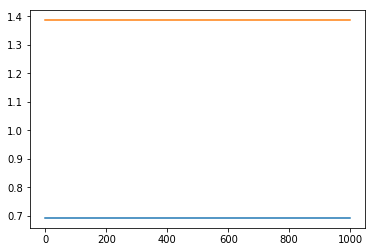

In [16]:
plt.plot(gen_loss_dir)
plt.plot(dis_loss_dir) ## After 25000 Iterations

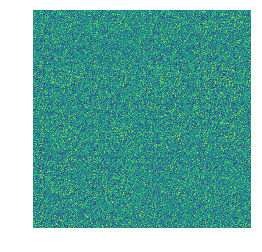

In [17]:
display_image(fake.reshape(-1, 64, 64), 4)